# Lezione 10

## Dario Pullia

Ci proponiamo di parallelizzare il programma della lezione 9 usando la libreria **MPI (Message Passing Interface)**.

Il calcolo parallelo è utile per ridurre i **tempi** di esecuzione di un programma a parità di **costo** computazionale. Di conseguenza bisogna tenere in considerazione che **non è una procedura di efficientamento**, ma solamente di distribuzione delle operazioni da compiere su diversi processori.



### Esercizio 10.1

In primo luogo eseguiamo il programma in parallelo 4 volte **modificando il seed** del generatore di numeri casuali. Questo permette di avere più popolazioni **indipendenti** che si evolvono e quindi permette di esplorare più minimi locali.

Applichiamo il problema alle 50 capitali degli USA usando 200 percorsi con 500 mutazioni per processore.

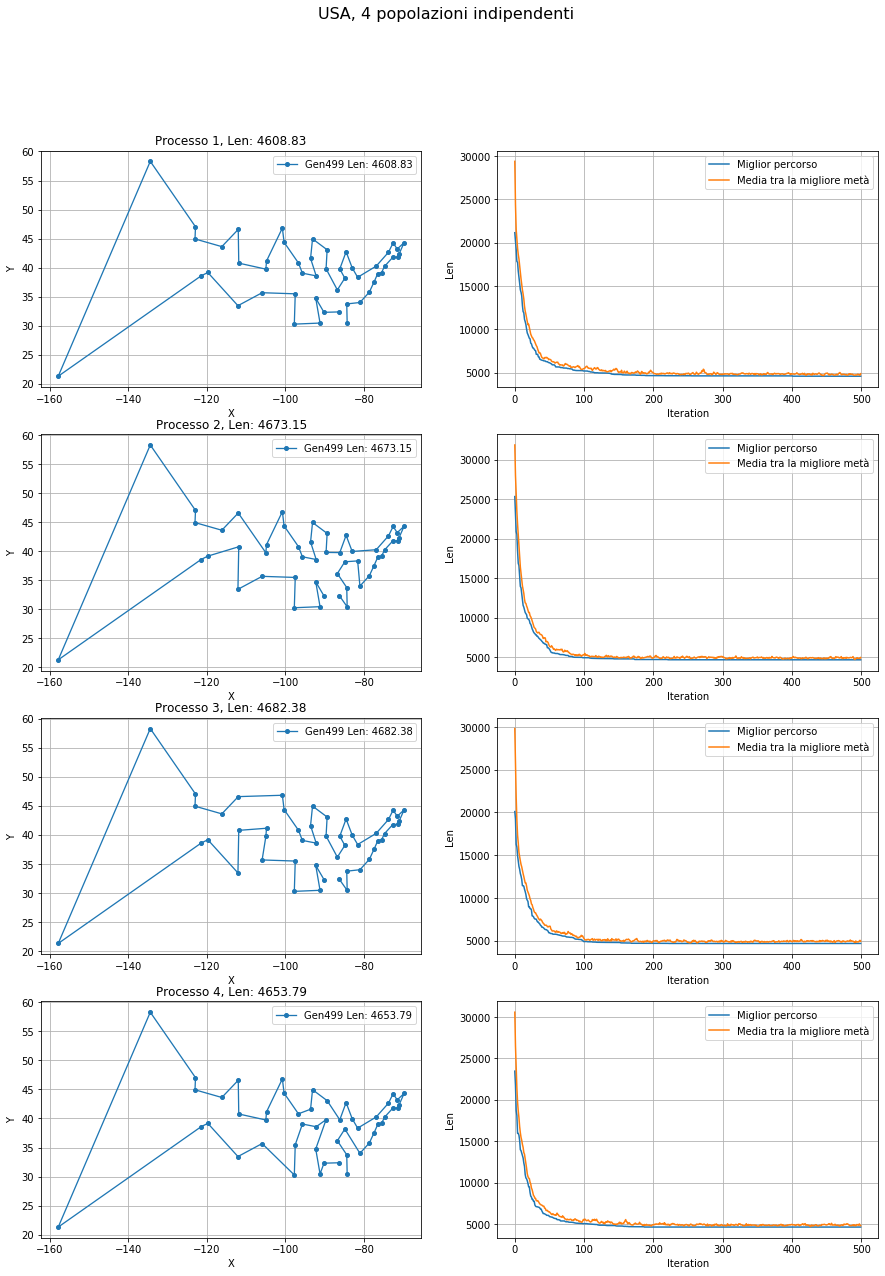

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import imageio


C=0
X,Y = np.loadtxt("data01/American_capitals/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(15, 20))
fig.suptitle("USA, 4 popolazioni indipendenti", fontsize=16)
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/American_capitals/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_title('Processo 1, Len: '+str(Best[M][N]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Miglior percorso')
ax2.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/American_capitals/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_title('Processo 2, Len: '+str(Best[M][N]))
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Miglior percorso')
ax4.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/American_capitals/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_title('Processo 3, Len: '+str(Best[M][N]))
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Miglior percorso')
ax6.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/American_capitals/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_title('Processo 4, Len: '+str(Best[M][N]))
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Miglior percorso')
ax8.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

La miglior soluzione è stata trovata dal processo 1 e tutte le altre soluzioni sono soddisfacenti.

### Esercizio 10.2

Per sfruttare al massimo la computazione parallela, implementiamo un sistema per cui ogni N mutazioni indipendenti può avvenire uno scambio di elementi tra le popolazioni. Questo permette ai singoli gruppi di rimanere indipendenti e al contempo di scambiarsi informazioni e aumentare l'esplorazione di diversi minimi.

#### Implementazione 

Ad ogni popolazione viene assegnato un *rank* da MPI. Facciamo in modo che ogni $N_{migr}$ mutazioni il processo 0 decida il numero di elementi che migreranno e lo comunica a tutti con **MPI_Bcast**. A questo punto tramite **MPI_Allgather** ogni processo comunica il numero corretto di percorsi a tutti e integra tra i propri i percorsi che ha ricevuto. 

$N_{migr}$ è definito arbitrariamente $N_{migr}=\frac{N_{paths}}{4}+1$ in modo che avvengano in tutto 4 migrazioni.

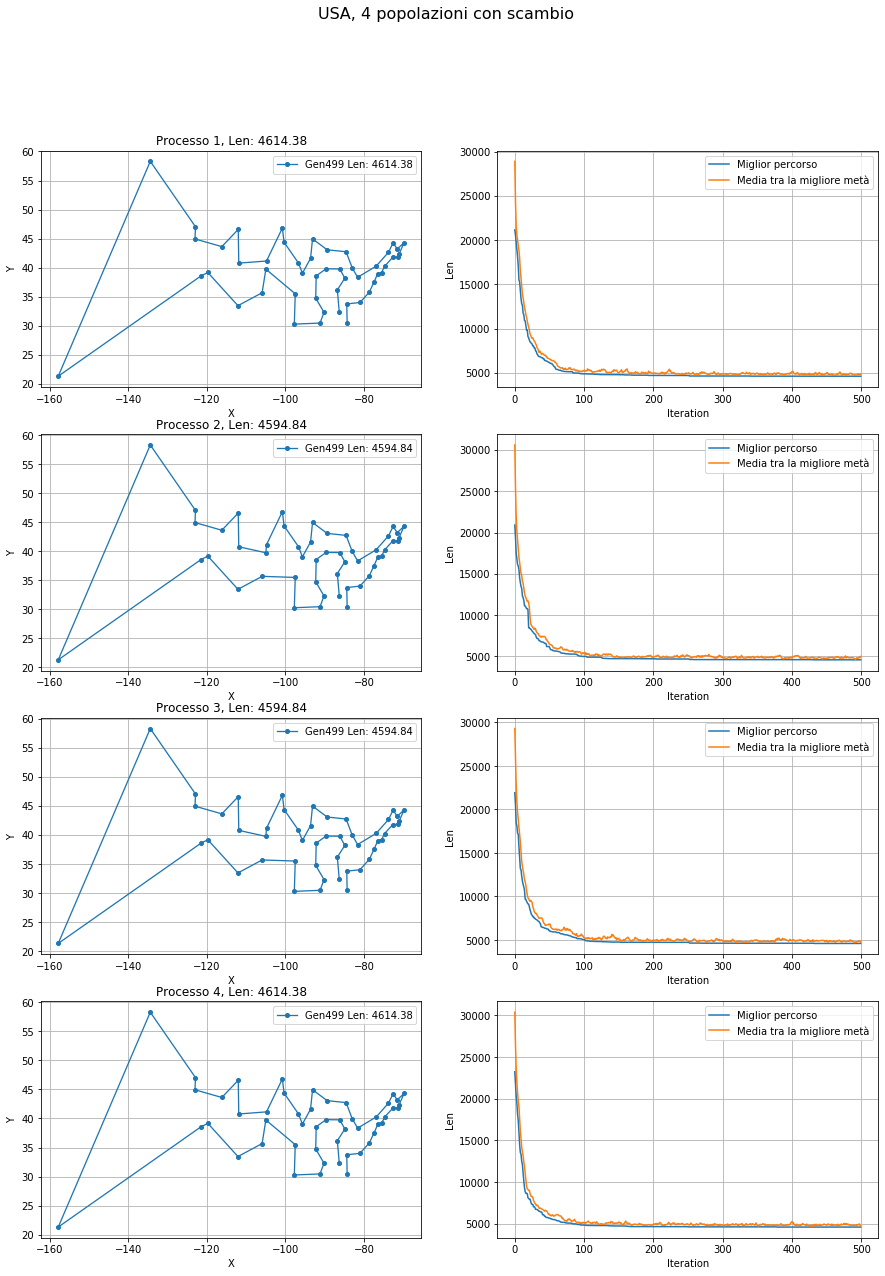

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import imageio


C=0
X,Y = np.loadtxt("data02/American_capitals/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(15, 20))
fig.suptitle("USA, 4 popolazioni con scambio", fontsize=16)
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/American_capitals/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_title('Processo 1, Len: '+str(Best[M][N]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Miglior percorso')
ax2.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/American_capitals/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_title('Processo 2, Len: '+str(Best[M][N]))
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Miglior percorso')
ax4.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/American_capitals/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_title('Processo 3, Len: '+str(Best[M][N]))
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Miglior percorso')
ax6.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/American_capitals/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_title('Processo 4, Len: '+str(Best[M][N]))
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Miglior percorso')
ax8.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

Rispetto al caso senza migrazioni abbiamo due processi (2,3) che hanno trovato una soluzione migliore. Notiamo che il risultato è nel complesso migliore in questa modalità.

Per divertimento ho preso anche i le [province Italiane](http://www.astrocom.it/main/symbols/province.htm) e ho rifatto le stesse operazioni ma usando 500 percorsi e 1500 mutazioni.

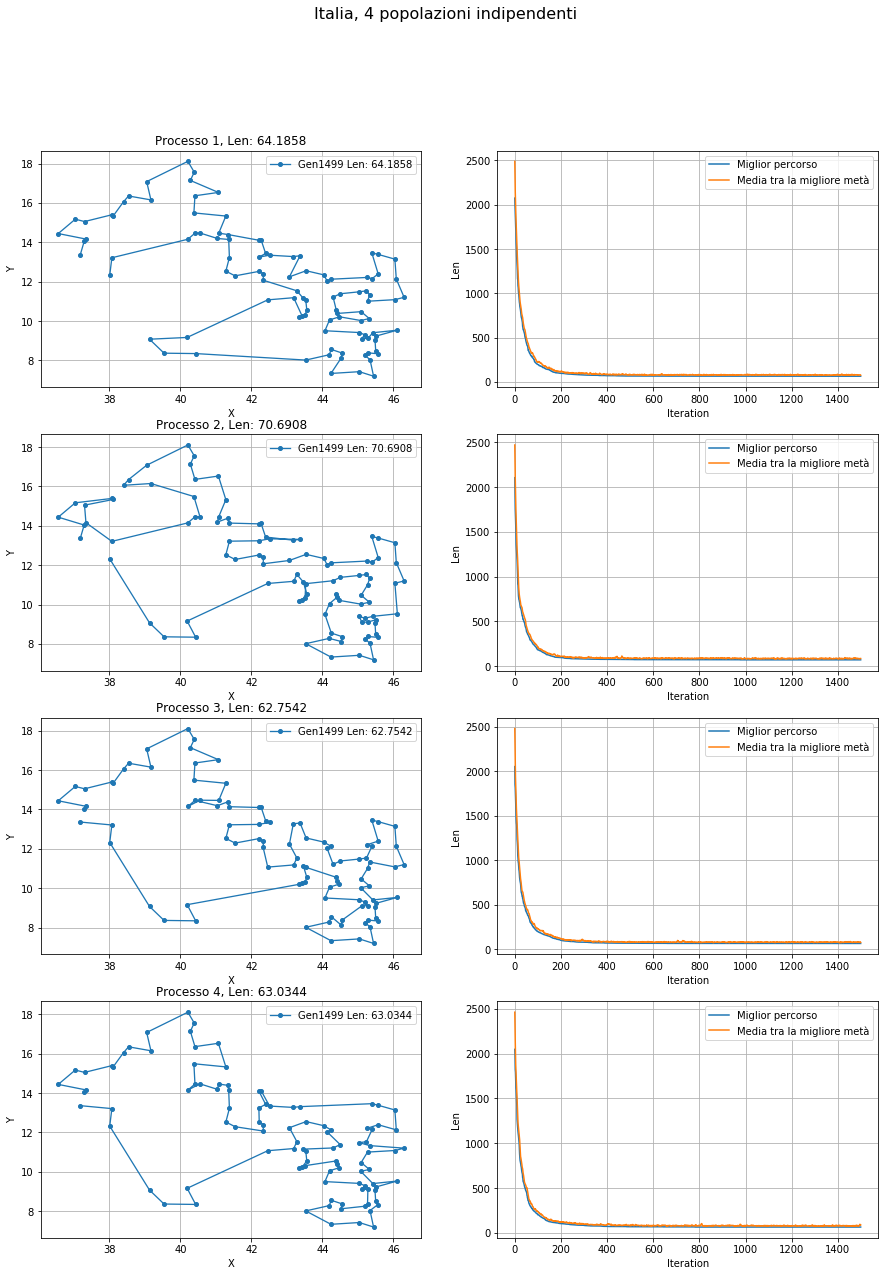

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import imageio


C=0
X,Y = np.loadtxt("data01/Capoluoghi/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(15, 20))
fig.suptitle("Italia, 4 popolazioni indipendenti", fontsize=16)
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/Capoluoghi/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_title('Processo 1, Len: '+str(Best[M][N]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Miglior percorso')
ax2.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/Capoluoghi/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_title('Processo 2, Len: '+str(Best[M][N]))
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Miglior percorso')
ax4.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/Capoluoghi/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_title('Processo 3, Len: '+str(Best[M][N]))
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Miglior percorso')
ax6.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/Capoluoghi/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_title('Processo 4, Len: '+str(Best[M][N]))
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Miglior percorso')
ax8.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

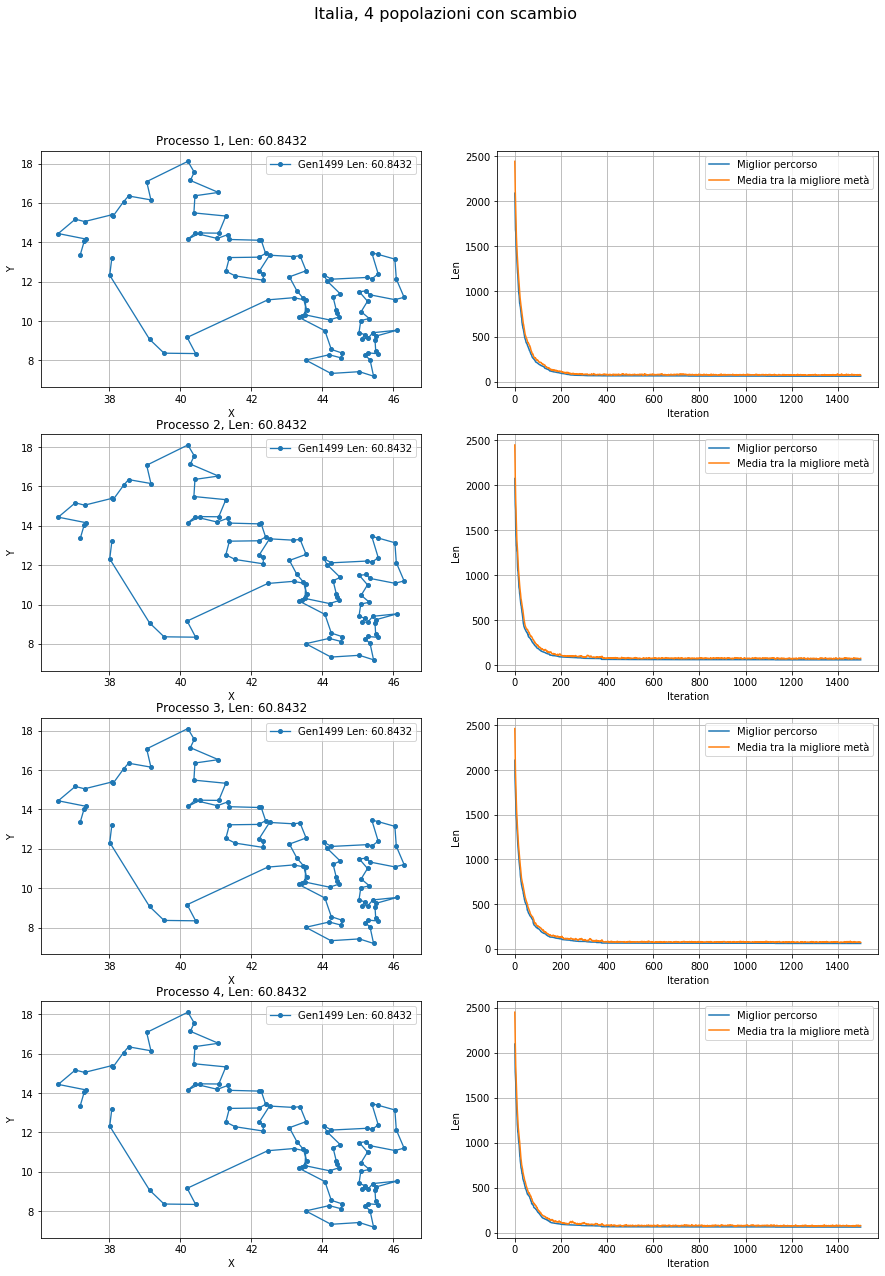

In [81]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import imageio


C=0
X,Y = np.loadtxt("data02/Capoluoghi/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(15, 20))
fig.suptitle("Italia, 4 popolazioni con scambio", fontsize=16)
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/Capoluoghi/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_title('Processo 1, Len: '+str(Best[M][N]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Miglior percorso')
ax2.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/Capoluoghi/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_title('Processo 2, Len: '+str(Best[M][N]))
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Miglior percorso')
ax4.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/Capoluoghi/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_title('Processo 3, Len: '+str(Best[M][N]))
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Miglior percorso')
ax6.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/Capoluoghi/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_title('Processo 4, Len: '+str(Best[M][N]))
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Miglior percorso')
ax8.plot(np.arange(M+1), LenAVG, label='Media tra la migliore metà')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()